## Emoji Polysemy Clustering: Prayer Hands

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, LatentDirichletAllocation
import emoji
from tqdm import tqdm
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import warnings


In [13]:
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

In [14]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Load in dataframe of emoji vectors

In [168]:
df = pd.read_pickle("emoji_vectors_data.pkl").set_index("tweet_id")
df.head()

,embedding,emoji_id
tweet_id,,
748304287315468288,"[-0.47280642, 0.11537896, 0.27408963, 0.137825...",871
593564841647992832,"[-0.20254304, -0.1832999, -0.08655356, 0.12977...",871
1189693284391833600,"[-0.29617956, -0.16728494, 0.20603363, 0.20679...",871
660244596664893440,"[-0.1807276, -0.016389936, 0.11193222, 0.14420...",871
538844422410993664,"[0.36076596, -0.046867955, 0.16463731, 0.15527...",871


Load in twitter metadata

In [184]:
tweets = pd.read_csv("tweets_data.csv").dropna(subset=["tweet_id"]).set_index("tweet_id")
tweets.head()

,author_id,created_at,geo,like_count,quote_count,reply_count,retweet_count,text
tweet_id,,,,,,,,
826217383039729664,431948312,2017-01-30 23:55:49+00:00,,0.0,0.0,0.0,0.0,We have the power👊💥😂💚 https://t.co/8en3JNwkny
869704038048202752,418718492,2017-05-30 23:56:15+00:00,,0.0,0.0,0.0,0.0,Sleep would be nice but Maiyahs cosies are bet...
792878143887605760,340099697,2016-10-30 23:57:35+00:00,{'place_id': '31fd9d42c71e7afa'},1.0,0.0,0.0,0.0,Lynn mad af cause Eric ate her chocolate chip ...
1322327339200630784,1249825087525728257,2020-10-30 23:59:39+00:00,,0.0,0.0,0.0,0.0,@KaileGedye text me cus I haven’t 🤣
979869505622069248,205097885,2018-03-30 23:54:29+00:00,,0.0,0.0,1.0,0.0,@juanlabia @Skelebird Yea but i feel like you ...


In [23]:
df.emoji_id.nunique()

47

There are 47 emojis to choose from

The emoji frequencies vary greatly.

In [24]:
emoji_freq = df.emoji_id.value_counts()
emoji_freq.head(15)

emoji_id
88      402897
247     163274
280     114094
390     103253
933      28369
1658     27541
1422     21795
491      15105
6239     15096
722      12182
663      12180
1651      8728
1548      7127
1382      6668
1277      6661
Name: count, dtype: int64

Display emoji frequencies in descending order using the actual emoji instead of the emoji id.

In [25]:
ef_index = emoji_freq.index
ef_index = ef_index.map(tokenizer.convert_ids_to_tokens)
emoji_freq.set_axis(ef_index.map(emoji.EMOJI_UNICODE_ENGLISH)).head(15)

emoji_id
😂     402897
😭     163274
❤️    114094
😍     103253
🙏      28369
✨      27541
🤣      21795
😩      15105
🥺      15096
😘      12182
💕      12180
💀       8728
💖       7127
🔥       6668
🏽       6661
Name: count, dtype: int64

### Prayer Hands

In this notebook I apply my methods to the prayer hands emoji.

In [185]:
prayer_hands_id = 933

prayer_hands_df = df.query("emoji_id == {}".format(prayer_hands_id)).drop("emoji_id", axis = 1)
prayer_hands_df

,embedding
tweet_id,
649010168466796544,"[0.17880017, 0.05944991, 0.029669717, 0.362047..."
649010168466796544,"[0.31431267, 0.11376719, -0.017697126, 0.36743..."
649010168466796544,"[0.27834195, 0.033847056, 0.08875726, 0.325185..."
1233542243899731968,"[-0.5153002, -0.07138766, 0.07983874, -0.02516..."
1454598713612046336,"[-0.49861014, 0.15797623, 0.02909191, 0.323536..."
...,...
693583914112159744,"[-0.17743944, 0.2504055, 0.19830742, 0.2940904..."
550078795202699264,"[0.22381634, 0.17009586, -0.054807916, 0.36430..."
550078795202699264,"[0.14281055, 0.17582378, -0.021657616, 0.57792..."


There are 28369 instances of the prayer hands emoji being used over the course of 8 years.

There are 21019 unique tweets that use the prayer hands emoji.

In [170]:
prayer_hands_df.index.nunique()

21019

A tiny sample of the tweets in this dataframe frequently use the prayer hands emojis

In [171]:
prayer_hands_df.index.value_counts()

tweet_id
615670335338233856     43
1046187630948429824    35
1079527433794137984    29
1012848168336179200    16
494633200657121280     15
                       ..
1277753287404593152     1
1012848084865486848     1
1454598945892618240     1
1322326937109409792     1
561312901492129792      1
Name: count, Length: 21019, dtype: int64

Let's see there are any temporal trends in the prayer hands emoji in this eight year time-span.

Connect the timestamp data from tweets by joining `tweets` with `prayer_hands_df`

In [187]:
prayer_hands_df = prayer_hands_df.join(tweets)

In [188]:
tweet_rate = pd.Series(index=pd.to_datetime(prayer_hands_df.created_at)).sort_index()

Plot the frequency of the prayer hands emoji appearing in tweets from 2014-2022

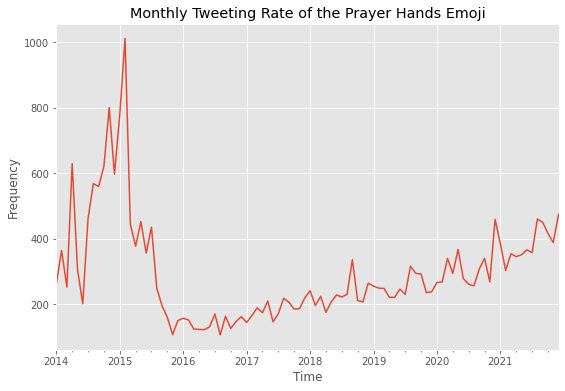

In [33]:
tweet_rate.resample("M").size().plot(figsize = (9,6))
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Monthly Tweeting Rate of the Prayer Hands Emoji");

There was a big spike in 2015, followed by a crash in 2016, and since then it's been on a steady uprise.

### Clustering

Now let's move onto the clustering. But first we need to prepare the embeddings data.

The embeddings are hosted in a single column and thus needed to be expanded into a dataframe whose number of columns matches the number of embedding dimensions (768).

In [172]:
prayer_embeddings = prayer_hands_df.embedding
prayer_embeddings.head()

tweet_id
649010168466796544     [0.17880017, 0.05944991, 0.029669717, 0.362047...
649010168466796544     [0.31431267, 0.11376719, -0.017697126, 0.36743...
649010168466796544     [0.27834195, 0.033847056, 0.08875726, 0.325185...
1233542243899731968    [-0.5153002, -0.07138766, 0.07983874, -0.02516...
1454598713612046336    [-0.49861014, 0.15797623, 0.02909191, 0.323536...
Name: embedding, dtype: object

Transform the data so that it each value in the embedding array is organized under a single column

In [173]:
prayer_embeddings = prayer_embeddings.apply(pd.Series)
prayer_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
tweet_id,,,,,,,,,,,,,,,,,,,,,
649010168466796544,0.178800,0.059450,0.029670,0.362048,-0.092572,-0.090097,0.056386,0.252641,0.187725,0.016247,...,0.187791,-0.361425,0.131782,0.127891,-0.284731,0.031908,0.065007,0.019091,-0.536011,0.011186
649010168466796544,0.314313,0.113767,-0.017697,0.367432,-0.031179,-0.103953,0.092101,0.188067,0.316456,0.267391,...,0.087665,-0.313290,0.101829,0.229156,-0.241067,-0.055159,0.007168,-0.049920,-0.391997,0.050951
649010168466796544,0.278342,0.033847,0.088757,0.325186,-0.001255,-0.589844,0.177111,0.269309,0.355679,0.166622,...,0.079534,-0.504104,-0.077147,0.052155,0.114016,0.118626,-0.132879,0.110086,-0.582188,-0.071241
1233542243899731968,-0.515300,-0.071388,0.079839,-0.025169,0.309406,-0.511755,0.300661,0.077642,0.342054,0.196609,...,0.272639,0.171139,-0.101986,0.448649,-0.298791,0.264860,-0.110508,-0.053058,-0.447471,-0.265488
1454598713612046336,-0.498610,0.157976,0.029092,0.323537,-0.170732,-0.101166,0.393581,0.203327,0.067146,-0.185658,...,0.379231,-0.281076,0.412709,-0.152941,0.028670,-0.278824,-0.020245,0.361500,-0.822515,0.226682


#### First clustering attempt

We begin with a simple KMeans model with k set to 3.

In [36]:
%%time
km = KMeans(n_clusters=3, random_state=10)
km.fit(prayer_embeddings)

CPU times: user 32.2 s, sys: 7.36 s, total: 39.6 s
Wall time: 3.79 s


KMeans(n_clusters=3, random_state=10)

In [37]:
prayer_labels_k3 = km.labels_

Evaluate model using silhouette score

In [38]:
silhouette_score(prayer_embeddings, prayer_labels_k3)

0.12503734

0.125 is not a bad score but we need to conduct parameter tuning in order to find the best k value.

In [39]:
sil_scores = []

k_range = range(2, 21)

for k in tqdm(k_range, total=19):
    km = KMeans(n_clusters=k, random_state=10)
    km.fit(prayer_embeddings)
    labels = km.labels_
    s_score = silhouette_score(prayer_embeddings, labels)
    sil_scores.append(s_score)

100%|███████████████████████████████████████████| 19/19 [08:07<00:00, 25.63s/it]


Plot the number of k values versus their corresponding silhouette scores.

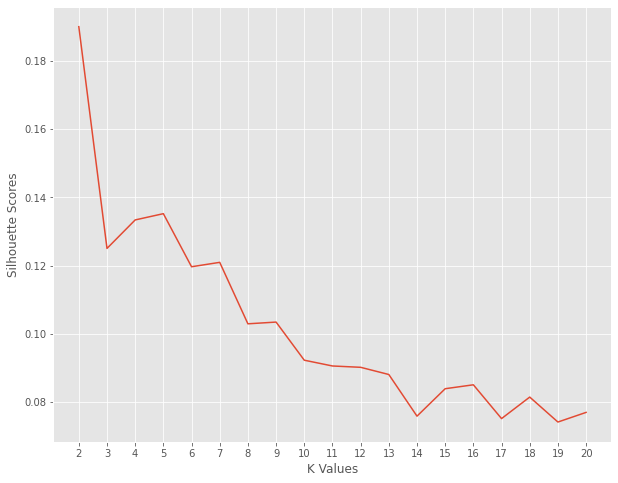

In [40]:
plt.figure(figsize = (10, 8))
plt.plot(k_range, sil_scores)
plt.xlabel("K Values")
plt.ylabel("Silhouette Scores")
plt.xticks(ticks = k_range);

2 is obviously the best k value (this is typically the case), but 5 is worth examining as becuase it's a local maximum and produces the second best score. 

Refit KMeans using 2 and 5 as k.

In [295]:
km2 = KMeans(n_clusters=2, random_state=10)
km2.fit(prayer_embeddings)
labels_2 = km2.labels_


km5 = KMeans(n_clusters=5, random_state=10)
km5.fit(prayer_embeddings)
labels_5 = km5.labels_

Transform the embeddings using TSNE for the purpose of plotting them in a 2D scatter plot, which will also use labels to color-encode the dots.

In [42]:
tsne = TSNE(random_state=10)
prayer_tsne = tsne.fit_transform(prayer_embeddings)

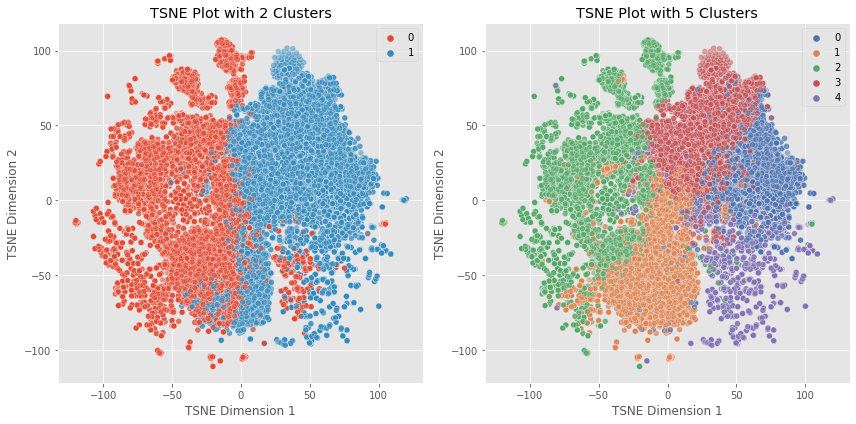

In [44]:
tsne1 = prayer_tsne[:, 0]
tsne2 = prayer_tsne[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatter plot on the left subplot

sb.scatterplot(x = tsne1, y = tsne2, hue=labels_2,ax = axs[0], alpha = .5)
axs[0].set_title('TSNE Plot with 2 Clusters')

# Plot the second scatter plot on the right subplot
sb.scatterplot(x = tsne1, y = tsne2, hue=labels_5,ax = axs[1], alpha = .5, palette = "deep")
axs[1].set_title('TSNE Plot with 5 Clusters')


axs[0].set_xlabel('TSNE Dimension 1')
axs[0].set_ylabel('TSNE Dimension 2')
axs[1].set_xlabel('TSNE Dimension 1')
axs[1].set_ylabel('TSNE Dimension 2')
fig.tight_layout()
plt.savefig("prayer_hands_tsne.png", dpi = 200)
# Show the plot
plt.show()


This is a promising result, we can observe distinguishable clusters of the prayer_hands emoji's meaning

What are the distributions of the labels for each model


Two clusters:

In [48]:
freq = pd.value_counts(labels_2).rename("Frequency")
prop = pd.value_counts(labels_2, normalize=True).rename("Proportions")
pd.concat([freq, prop], axis = 1)

,Frequency,Proportions
0,14539,0.512496
1,13830,0.487504


Five clusters:

In [49]:
freq = pd.value_counts(labels_5).rename("Frequency")
prop = pd.value_counts(labels_5, normalize=True).rename("Proportions")
pd.concat([freq, prop], axis = 1)

,Frequency,Proportions
2,9479,0.334132
1,6377,0.224788
3,5409,0.190666
0,3864,0.136205
4,3240,0.114209


Now let's dive into what those clusters mean.

In [296]:
prayer_hands_df["labels2"] = labels_2
prayer_hands_df["labels5"] = labels_5

Remember that `prayer_hands_df` has duplicate tweets because each row represent one use of the prayer hands emoji and in some tweets there are multitple instances of that emoji.

Here I group by the `tweet_id` and apply the `value_counts` function to the cluster labels

In [298]:
labels2_df = prayer_hands_df.reset_index().groupby("tweet_id").labels2.value_counts().unstack().fillna(0)
labels2_df.head()

labels2,0,1
tweet_id,,
429040710663168000,1.0,0.0
429040711967993856,1.0,0.0
429040712110186496,1.0,0.0
429040713247256576,0.0,1.0
429040714149007360,0.0,1.0


`labels2_df` shows the frequency of each cluster appearing in a tweet.

Repeat this process for 5 labels

In [299]:
labels5_df = prayer_hands_df.reset_index().groupby("tweet_id").labels5.value_counts().unstack().fillna(0)
labels5_df.head()

labels5,0,1,2,3,4
tweet_id,,,,,
429040710663168000,0.0,0.0,1.0,0.0,0.0
429040711967993856,0.0,0.0,1.0,0.0,0.0
429040712110186496,0.0,0.0,1.0,0.0,0.0
429040713247256576,1.0,0.0,0.0,0.0,0.0
429040714149007360,0.0,0.0,0.0,1.0,0.0


### Defining topics 

Here I bring in the topic, emotions, and sentiment data. This extra data is used to help us distinguish between the emoji clusters. 

In [109]:
topics = pd.read_pickle("topic_scores_df.pkl")
emotions = pd.read_csv("tweet_emotions.csv", index_col=[0])
sentiment = pd.read_csv("sentiments.csv", index_col=[0])

### Two labels

#### Topics 

In [143]:
def mean_topics(labels_df):
    label_means = []
    
    for i in labels_df.columns:
        mean_topic_cluster = topics.loc[labels_df[labels_df.loc[:, i]==1].index].mean().rename("cluster_{}_scores".format(i))
        label_means.append(mean_topic_cluster)
        
    label_means = pd.concat(label_means, axis = 1)
    if labels_df.shape[1] > 2:
        label_means["standard_dev"] = label_means.std(axis = 1)
        label_means.sort_values("standard_dev", ascending = True, inplace=True)
    else:
        label_means["absolute_difference"] = label_means.diff(axis = 1).iloc[:, 1].abs()
        label_means.sort_values("absolute_difference", ascending=True, inplace=True)
    
    return label_means
    

In [144]:
two_label_topics_scores = mean_topics(labels2_df)
two_label_topics_scores

,cluster_0_scores,cluster_1_scores,absolute_difference
travel_&_adventure,0.019542,0.020296,0.000754
science_&_technology,0.013683,0.014636,0.000954
food_&_dining,0.019224,0.021909,0.002686
fashion_&_style,0.019041,0.022286,0.003246
gaming,0.011202,0.014763,0.003561
business_&_entrepreneurs,0.031847,0.037708,0.005860
news_&_social_concern,0.185247,0.178047,0.007200
learning_&_educational,0.026985,0.019545,0.007440
arts_&_culture,0.081565,0.089596,0.008032
youth_&_student_life,0.018647,0.010207,0.008440


On what topics do the two cluster labels differ the most

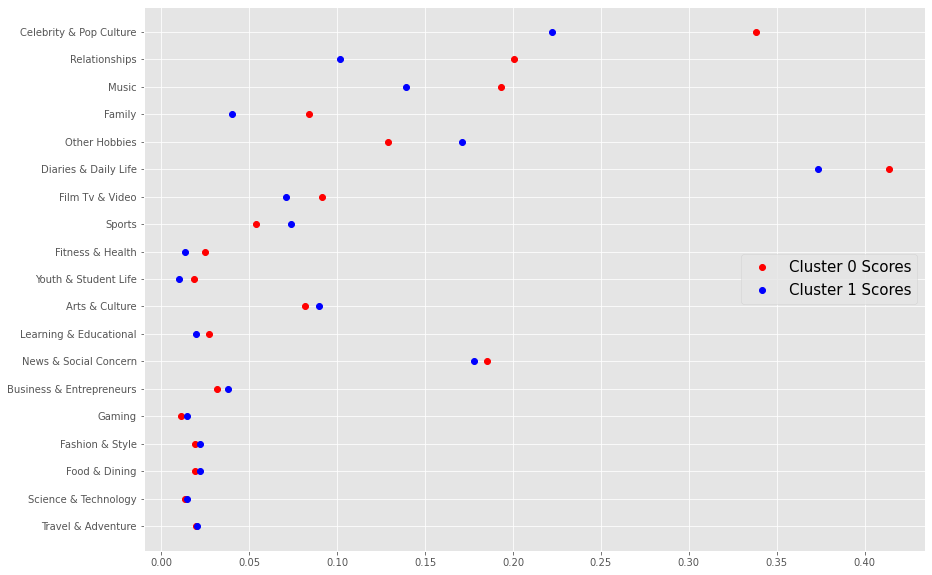

In [105]:
plt.figure(figsize=(14, 10))

y_ticks = two_label_topics_scores.index.str.replace("_", " ").str.title().tolist()
plt.plot(two_label_topics_scores.cluster_0_scores.values, 
         y_ticks, "ro", label = "Cluster 0 Scores")

plt.plot(two_label_topics_scores.cluster_1_scores.values, 
         y_ticks, "bo", label = "Cluster 1 Scores")
plt.legend(loc = 5, fontsize = 15)
plt.show()

#### Emotions

In [145]:
def mean_emotions_sentiment(labels_df):
    label_emotion_means = []
    label_sentiment_means = []
    
    for i in labels_df.columns:
        mean_emotion_cluster = emotions.loc[labels_df[labels_df.loc[:, i]==1].index].mean().rename("cluster_{}_scores".format(i))
        label_emotion_means.append(mean_emotion_cluster)
        
    for i in labels_df.columns:
        mean_sentiment_cluster = sentiment.loc[labels_df[labels_df.loc[:, i]==1].index].mean().rename("cluster_{}_scores".format(i))
        label_sentiment_means.append(mean_sentiment_cluster)
        
    label_emotion_means = pd.concat(label_emotion_means, axis = 1)
    label_emotion_means.index = "Emotion_" + label_emotion_means.index
    label_sentiment_means = pd.concat(label_sentiment_means, axis = 1)
    label_sentiment_means.index = "Sentiment_" + label_sentiment_means.index
    
    label_means = pd.concat([label_emotion_means, label_sentiment_means])
    
    if labels_df.shape[1] > 2:
        label_means["standard_dev"] = label_means.std(axis = 1)
        label_means.sort_values("standard_dev", ascending = True, inplace=True)
    else:
        label_means["absolute_difference"] = label_means.diff(axis = 1).iloc[:, 1].abs()
        label_means.sort_values("absolute_difference", ascending=True, inplace=True)
    
    return label_means
    

In [146]:
two_label_emotion_sentiment = mean_emotions_sentiment(labels2_df)
two_label_emotion_sentiment

,cluster_0_scores,cluster_1_scores,absolute_difference
Sentiment_NEG,0.069434,0.070339,0.000905
Emotion_anger,0.005583,0.006493,0.000910
Emotion_disgust,0.013704,0.015190,0.001486
Emotion_surprise,0.005583,0.009810,0.004227
Emotion_fear,0.012408,0.006831,0.005576
Emotion_sadness,0.145993,0.112049,0.033944
Emotion_joy,0.404023,0.352342,0.051681
Emotion_others,0.412705,0.497284,0.084579
Sentiment_NEU,0.230496,0.399885,0.169389
Sentiment_POS,0.700070,0.529775,0.170294


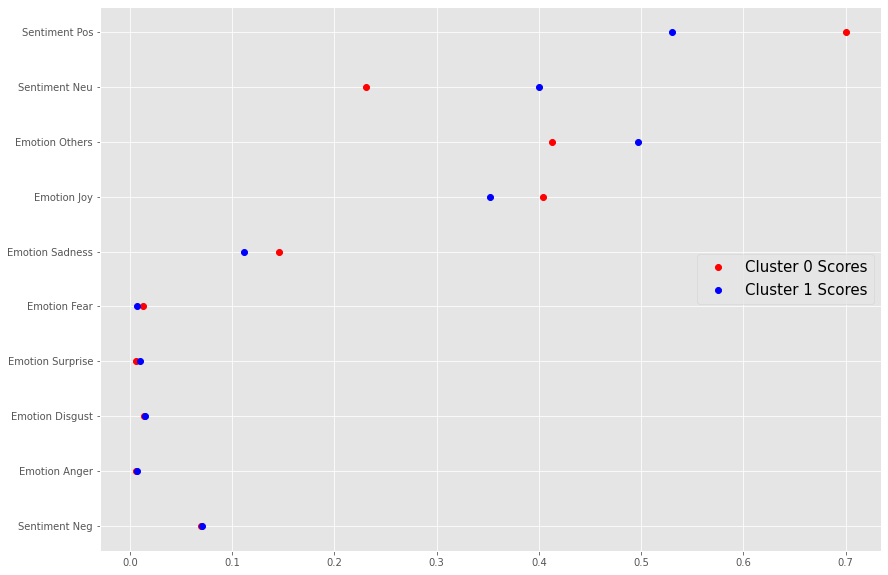

In [141]:
plt.figure(figsize=(14, 10))

y_ticks = two_label_emotion_sentiment.index.str.replace("_", " ").str.title().tolist()
plt.plot(two_label_emotion_sentiment.cluster_0_scores.values, 
         y_ticks, "ro", label = "Cluster 0 Scores")

plt.plot(two_label_emotion_sentiment.cluster_1_scores.values, 
         y_ticks, "bo", label = "Cluster 1 Scores")
plt.legend(loc = 5, fontsize = 15)
plt.show()

### Five Labels

In [156]:
five_label_topics_scores = mean_topics(labels5_df)
five_label_topics_scores.round(3)

,cluster_0_scores,cluster_1_scores,cluster_2_scores,cluster_3_scores,cluster_4_scores,standard_dev
science_&_technology,0.012,0.021,0.010,0.012,0.007,0.005
gaming,0.013,0.019,0.008,0.012,0.005,0.005
fashion_&_style,0.026,0.026,0.017,0.013,0.020,0.006
youth_&_student_life,0.008,0.021,0.017,0.007,0.005,0.007
food_&_dining,0.016,0.028,0.016,0.018,0.009,0.007
fitness_&_health,0.012,0.027,0.023,0.010,0.009,0.008
travel_&_adventure,0.021,0.029,0.016,0.014,0.006,0.009
learning_&_educational,0.016,0.033,0.023,0.015,0.007,0.010
business_&_entrepreneurs,0.032,0.045,0.023,0.028,0.044,0.010
arts_&_culture,0.094,0.081,0.083,0.103,0.051,0.020


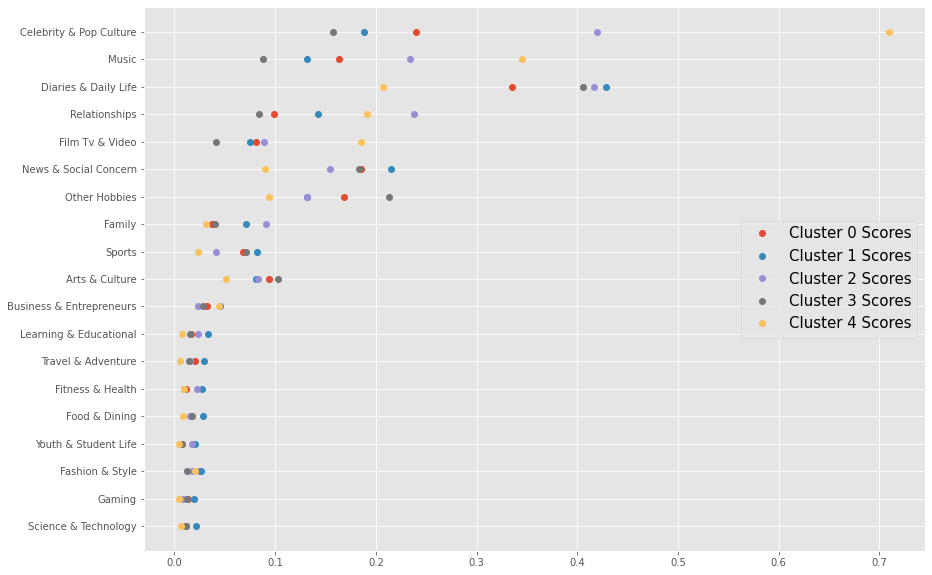

In [155]:
plt.figure(figsize=(14, 10))

y_ticks = five_label_topics_scores.index.str.replace("_", " ").str.title().tolist()

cluster_columns = five_label_topics_scores.columns[:5]

for col in cluster_columns:
    ser = five_label_topics_scores[col].values
    plt.plot(ser, y_ticks, "o", label = col.replace("_", " ").title())

plt.legend(loc = 5, fontsize = 15)
plt.show()

## Centriod Tweets


Show the 15 closest tweets to the centriods

### Two labels

In [191]:
two_label_dists = euclidean_distances(km2.cluster_centers_, prayer_embeddings)
two_label_dists_argsort = two_label_dists.argsort(axis = 1)

In [192]:
def centriod_tweets(dists_argsort, n = 5):    
    output = {}
    
    for i in range(len(dists_argsort)):
        row = dists_argsort[i]
        top_n_args = row[:n]
        tweet_ids = prayer_embeddings.index[top_n_args]
        output["cluster_{}".format(i)] = tweets.loc[tweet_ids].text.tolist()
    return output

Print out the the 15 tweets closest to each centriod

In [200]:
for k, v in centriod_tweets(two_label_dists, 15).items():
    print(k.title()+":\n")
    for i in v:
        print("|",i, "|")
    print("\n")

Cluster_0:

| @Michael5SOS Hahah, I love you Mikey xx Please come to Japannn🇯🇵❤️🙏 |
| @HeffronDrive I would do anything to get a follow from you. . Please? 🙏 |
| So my son decided to run the Win11 installer on my audio computer. Pray for me! 🙏 https://t.co/baxRZ9uBap |
| @mrdanfogler so good know that another countries are praying for Brazil... Thanks Dan, we love u.🙏 |
| @JMcNeil_ @humbercollege @HumberLakeshore @HumberAlumni Justine, sending your positive vibes and hope you’ll be back soon. 🙏 |
| @ayudamds Can you give me a one RT please?😭❤️ Make my dream true🙏https://t.co/8tiun5Sgp8 |
| Persevere... Preserve... Pray..🙏 https://t.co/8C1nbNjHVr |
| @CryptoKing1st @wamcoin Done.... wish me luck ..Thank You so much..🙏💕Tg : csy_uty https://t.co/ERSjBoh2Kx |
| I FINALY FINISHED THIS!
me and @WillowShields
please notice this willow! 💞🙏 http://t.co/XTc03kOsfS |
| @steveo @bioXcellerator Please God, let Steve-O live forever. He is a national treasure and needs to be appreciated for millennia

In [201]:
five_label_dists = euclidean_distances(km5.cluster_centers_, prayer_embeddings)
five_label_dists_argsort = five_label_dists.argsort(axis = 1)

In [204]:
for k, v in centriod_tweets(five_label_dists_argsort, 15).items():
    print(k.title()+":\n")
    for i in v:
        print("|",i, "|")
    print("\n")

Cluster_0:

| @SunandStilettos @oprahmagazine Thank you so much!!!! 🙏❤️🙏❤️ |
| @officialnairam1 Save our life please 🙏😭😭🙏🙏 https://t.co/1N3IbjHrqc |
| @elbetterlife Claimed and received with gratitude!💯💖🙏 https://t.co/aDQxpV4zxX |
| @VapingKaren @Kloudyvapes @SJS_Survivor @Heavenlyink @che170 Thanks and good luck hun 🤞🙏🙏🤣 |
| @CistaAfriyie At all cost 💖💖💖🙏🙏 |
| @officialnairam1 Save our life please 🙏😭😭🙏🙏 https://t.co/1N3IbjHrqc |
| @Bang_Garr @Gaussproject_ Done, manifesting to win🙏❤️ https://t.co/yuxXEGQAVt |
| Efferim Ecot 🙏🙏🎈🎈 https://t.co/dhcFzE2F7O |
| @QUEENNI16 God ...when?🤔😫🙏🙏 |
| Pledged and sharing. ❤️❤️❤️🙏🏻 https://t.co/vG5upMpt3S |
| @SOLODMSOF1D Yo pleasee 😭🙏🙏 https://t.co/27RKCekCCr |
| inlove with the KAMCAM. 🙌🙏 @KalinAndMyles @KalinWhite @YourBoyMyles |
| @JohnCena @tdgarden @WWE @WWEonFOX The legend is back🙏🙏🙏 |
| Don't tease!!! 😭🙏🙏🙏💚💛 https://t.co/xtV7qBGBme |
| Efferim Ecot 🙏🙏🎈🎈 https://t.co/dhcFzE2F7O |


Cluster_1:

| @Trumpster5280 We have to have faith that the T

Most distinctive words

In [205]:
prayer_text = prayer_hands_df.reset_index().groupby("tweet_id").text.unique().apply(lambda x:x[0])
prayer_text.head()

tweet_id
429040710663168000                      Saturday please come sooner! 🙏💕
429040711967993856                              i just hope he okayy. 🙏
429040712110186496    Everything is falling into place💗 #steadyprogr...
429040713247256576              2 hr delay for now, praying for more 🙏👼
429040714149007360           New phone comes in tomorrow than godddd!🙏😍
Name: text, dtype: object

In [263]:
countvec = CountVectorizer(max_df=0.5, min_df=0.005,preprocessor=tokenizer.normalizeTweet, stop_words="english")
prayer_dtm = countvec.fit_transform(prayer_text).toarray()
features = countvec.get_feature_names_out()
prayer_dtm = pd.DataFrame(index=prayer_text.index, data = prayer_dtm, columns = features)

In [270]:
def words_ratio(labels_df):
    output = {}
    for i in labels_df.columns:
        label_ids = labels_df[labels_df.loc[:, i] == 1].index
        
        word_counts_label = prayer_dtm.loc[label_ids].sum()
        word_counts_label_norm = word_counts_label/word_counts_label.sum()
        
        word_counts_out_of_label = prayer_dtm.drop(label_ids).sum().replace(0, 1)
        word_counts_out_of_label_norm = word_counts_out_of_label/word_counts_out_of_label.sum()
        ratio = word_counts_label_norm/word_counts_out_of_label_norm
        output["cluster_{}".format(i)] = ratio
    return output

In [271]:
labels2_ratios = words_ratio(labels2_df)

In [272]:
for k, v in labels2_ratios.items():
    
    print("Most distinctive words in {}\n".format(k))
    print(v.nlargest(10), "\n")

Most distinctive words in cluster_0

gift              15.477046
Could              5.843736
YOUR               5.415364
birthday           4.350744
loves              4.065528
strong             3.960386
AaronsNewVideo     3.633741
important          3.604902
Hey                3.364575
followed           3.364575
dtype: float64 

Most distinctive words in cluster_1

movie_camera                    7.773190
collision                       6.626967
Done                            3.906284
smiling_face_with_sunglasses    3.744379
rose                            3.236457
Thanks                          3.070851
face_with_tears_of_joy          3.013163
sparkles                        2.792066
bro                             2.781748
clapping_hands                  2.749386
dtype: float64 



In [273]:
labels5_ratios = words_ratio(labels5_df)

In [274]:
for k, v in labels5_ratios.items():
    
    print("Most distinctive words in {}\n".format(k))
    print(v.nlargest(10), "\n")

Most distinctive words in cluster_0

movie_camera                    13.421704
rose                             6.887454
clapping_hands                   5.594084
smiling_face_with_sunglasses     3.789658
face_with_tears_of_joy           3.472181
flexed_biceps                    3.243579
dark_skin_tone                   3.107072
thumbs_up                        2.962423
collision                        2.916843
OK_hand                          2.836860
dtype: float64 

Most distinctive words in cluster_1

change     9.512538
gonna      6.877514
ll         5.603900
support    5.463143
work       5.036049
time       4.740334
just       4.623858
look       4.364576
feel       4.122100
believe    4.104780
dtype: float64 

Most distinctive words in cluster_2

gift        11.623835
followed     6.290061
strong       4.187300
Could        4.097196
Hey          3.631628
Do           3.324667
proud        2.999889
CAN          2.979631
smile        2.949548
days         2.886089
dtype: float64 

In [277]:
prayer_hands_time = prayer_hands_df[["created_at"]]

In [278]:
labels2_df = labels2_df.join(prayer_hands_time)

In [279]:
labels2_df["created_at"] = pd.to_datetime(labels2_df.created_at)

In [280]:
labels2_tweetrate = labels2_df.set_index("created_at").loc[:, [0,1]]
labels2_tweetrate.head()

,0,1
created_at,,
2014-01-30 23:57:31+00:00,0.0,1.0
2014-01-30 23:57:31+00:00,1.0,0.0
2014-01-30 23:57:31+00:00,0.0,1.0
2014-01-30 23:57:31+00:00,1.0,0.0
2014-01-30 23:57:32+00:00,1.0,0.0


(0.0, 1.0)

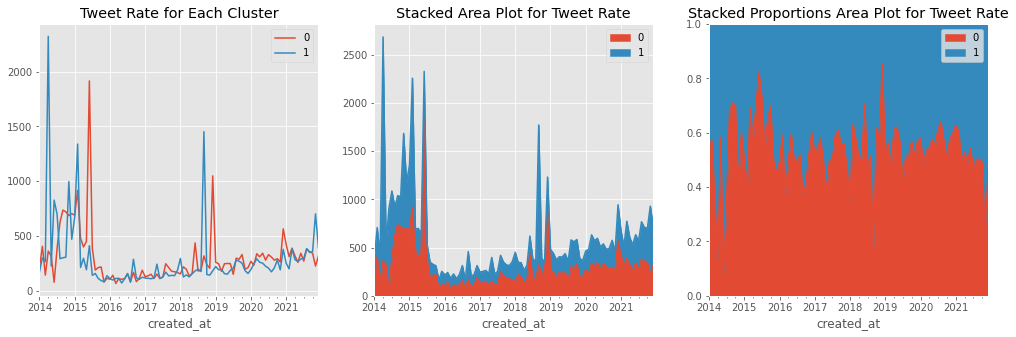

In [281]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

monthly_rate = labels2_tweetrate.resample("M").sum()
monthly_rate.plot(ax = axes[0])

axes[0].set_title('Tweet Rate for Each Cluster')

monthly_rate.plot(kind = "area", ax = axes[1])

axes[1].set_title('Stacked Area Plot for Tweet Rate')

monthly_rate.divide(monthly_rate.sum(axis = 1),axis = 0).plot(kind = "area", ax = axes[2])

axes[2].set_title('Stacked Proportions Area Plot for Tweet Rate')
axes[2].set_ylim(0, 1)
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.title("Monthly Tweeting Rate of the Prayer Hands Emoji");

In [300]:
labels5_df = labels5_df.join(prayer_hands_time)

In [301]:
labels5_df["created_at"] = pd.to_datetime(labels5_df.created_at)

In [302]:
labels5_tweetrate = labels5_df.set_index("created_at").loc[:, [0,1,2,3,4]]
labels5_tweetrate.head()

,0,1,2,3,4
created_at,,,,,
2014-01-30 23:57:31+00:00,0.0,0.0,1.0,0.0,0.0
2014-01-30 23:57:31+00:00,0.0,0.0,1.0,0.0,0.0
2014-01-30 23:57:31+00:00,0.0,0.0,1.0,0.0,0.0
2014-01-30 23:57:31+00:00,1.0,0.0,0.0,0.0,0.0
2014-01-30 23:57:32+00:00,0.0,0.0,0.0,1.0,0.0


In [303]:
labels5_tweetrate.index = pd.to_datetime(labels5_tweetrate.index)

Text(0.5, 1.0, 'Stacked Proportions Area Plot for Tweet Rate')

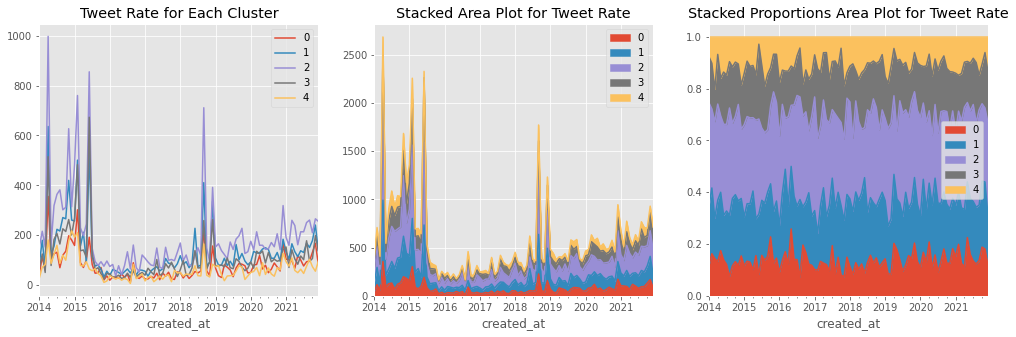

In [304]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

monthly_rate = labels5_tweetrate.resample("M").sum()
monthly_rate.plot(ax = axes[0])

axes[0].set_title('Tweet Rate for Each Cluster')

monthly_rate.plot(kind = "area", ax = axes[1])

axes[1].set_title('Stacked Area Plot for Tweet Rate')

monthly_rate.divide(monthly_rate.sum(axis = 1),axis = 0).plot(kind = "area", ax = axes[2])

axes[2].set_title('Stacked Proportions Area Plot for Tweet Rate')